In [9502]:
import sys
sys.path.append("..")

In [9503]:
import torch
torch.__version__

'1.13.1'

In [9504]:
import numpy as np
from torch.utils.data import Dataset
from glob import glob
from skimage import io
import os
from torchvision import datasets, transforms
import matplotlib
import os
import gc
import random
from datetime import date, datetime
import json
import pprint
from skimage.filters import threshold_otsu
import pyperclip
os.cpu_count()

20

In [9505]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [9506]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2023-05-14 21:28:26


In [9507]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [9508]:
from dataset.data_loaders import *
from dataset.utils.plot_utils import plot_s1s2_tensors, save_s1s2_tensors_plot
#from config import *
from train_utils import *

In [9509]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [9510]:
def get_ones_ratio(arr):
    if len(arr.shape) == 3:
        arr = arr.squeeze(0)
    ones_count = np.count_nonzero(arr == 1)
    total_pixels = arr.shape[0] * arr.shape[1]
    ratio = ones_count / total_pixels
    return ratio

In [9511]:
s1_t1_dir_train="E:\\s1s2\\2021\\s1_imgs\\test"
s2_t1_dir_train="E:\\s1s2\\2021\\s2_imgs\\test"
s1_t2_dir_train="E:\\s1s2\\2019\\s1_imgs\\test"
s2_t2_dir_train="E:\\s1s2\\2019\\s2_imgs\\test"
s1_t1_dir_test="E:\\s1s2\\2021\\s1_imgs\\test"
s2_t1_dir_test="E:\\s1s2\\2021\\s2_imgs\\test"
s1_t2_dir_test="E:\\s1s2\\2019\\s1_imgs\\test"
s2_t2_dir_test="E:\\s1s2\\2019\\s2_imgs\\test"

In [9512]:
transform = transforms.Compose([S2S1Normalize(),myToTensor()])
test_dataset = Sen12Dataset(s1_t1_dir=s1_t1_dir_test,
                            s2_t1_dir=s2_t1_dir_test,
                            s1_t2_dir=s1_t2_dir_test,
                            s2_t2_dir=s2_t2_dir_test,
                            transform=transform,
                            two_way=True)


In [9513]:
rand_n = random.randint(0, len(test_dataset))
print(f"{rand_n} / {len(test_dataset)}")

0 / 1354


In [9514]:
rand_n =-1

# THIS

0 / 1354


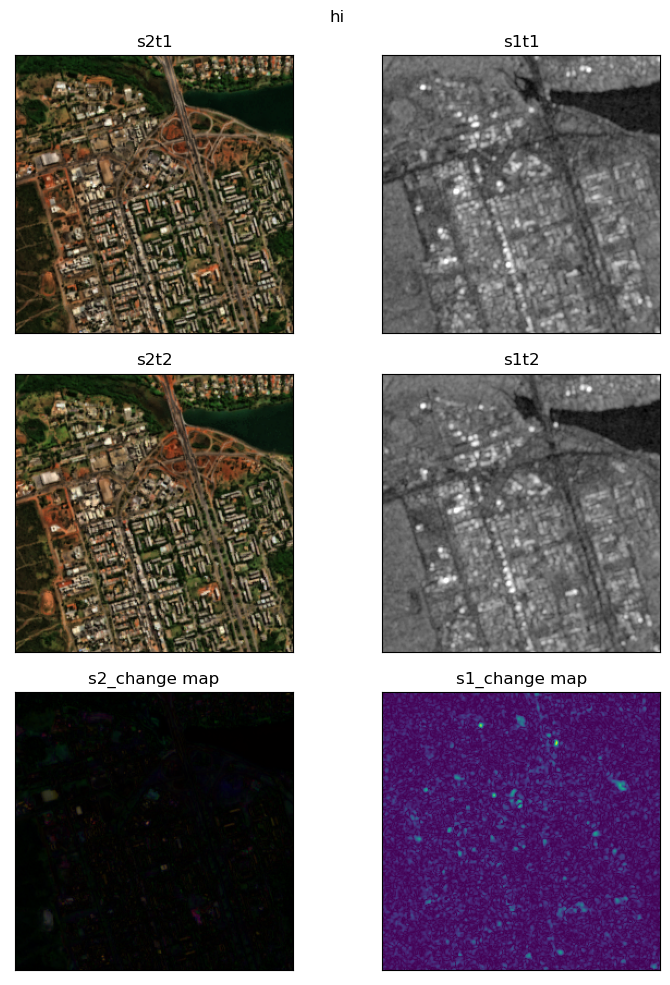

In [9515]:
rand_n +=1
print(f"{rand_n} / {len(test_dataset)}")
s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm = test_dataset[rand_n]
input_list = [s2t1,s1t1,s2t2,s1t2,torch.abs(cm),s1cm]

save_s1s2_tensors_plot(input_list,
                        ["s2t1", "s1t1", "s2t2", "s1t2", "s2_change map", "s1_change map"],
                        n_rows=3,
                        n_cols=2,
                        filename=f"1.png",
                        fig_size=(8,10),
                        title="hi", just_show=True)

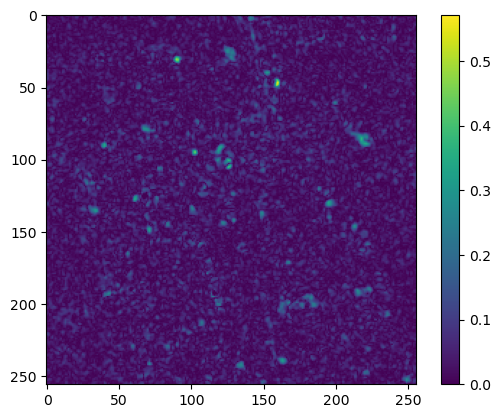

In [9516]:
diff = s1cm
plt.imshow(diff[0,:,:])
plt.colorbar()

In [9517]:
diff_np = diff.numpy()
thresh = threshold_otsu(diff_np)
thresh

0.0525

In [9518]:
thresh = 0.09

In [9519]:
binary_diff = (diff_np > thresh).astype(int)
get_ones_ratio(binary_diff) * 100

5.59844970703125

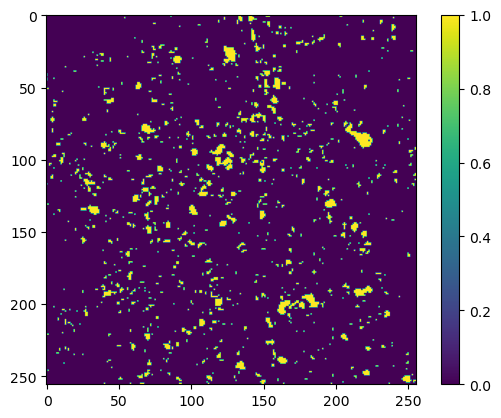

In [9520]:
plt.imshow(binary_diff[0,:,:])
plt.colorbar()

In [9521]:
import skimage

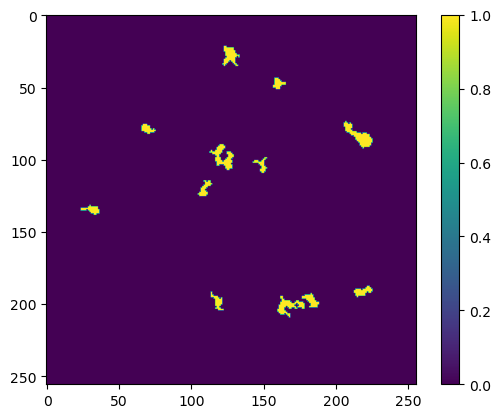

In [9522]:
morphed_image =binary_diff[0,:,:]
morphed_image = skimage.morphology.binary_closing(morphed_image)
#morphed_image = skimage.morphology.diameter_opening(morphed_image, 5)
morphed_image = skimage.morphology.remove_small_objects(morphed_image, min_size=40)
plt.imshow(morphed_image)
plt.colorbar()

In [9523]:
get_ones_ratio(morphed_image) * 100

1.3092041015625

In [9524]:
# masking s1t1 with morphed_image
masked_s1t1 = (s1t1 * 0.5 + 0.5) * (morphed_image+0.1)
# masking s1t2 with morphed_image
masked_s1t2 = (s1t2 * 0.5 + 0.5) * (morphed_image+0.1)
# morphed_image is a numpy array, so we need to convert it to a tensor
morphed_image_tensor = torch.from_numpy(morphed_image)
# unsqueeze to add a channel dimension
morphed_image_tensor = morphed_image_tensor.unsqueeze(0)

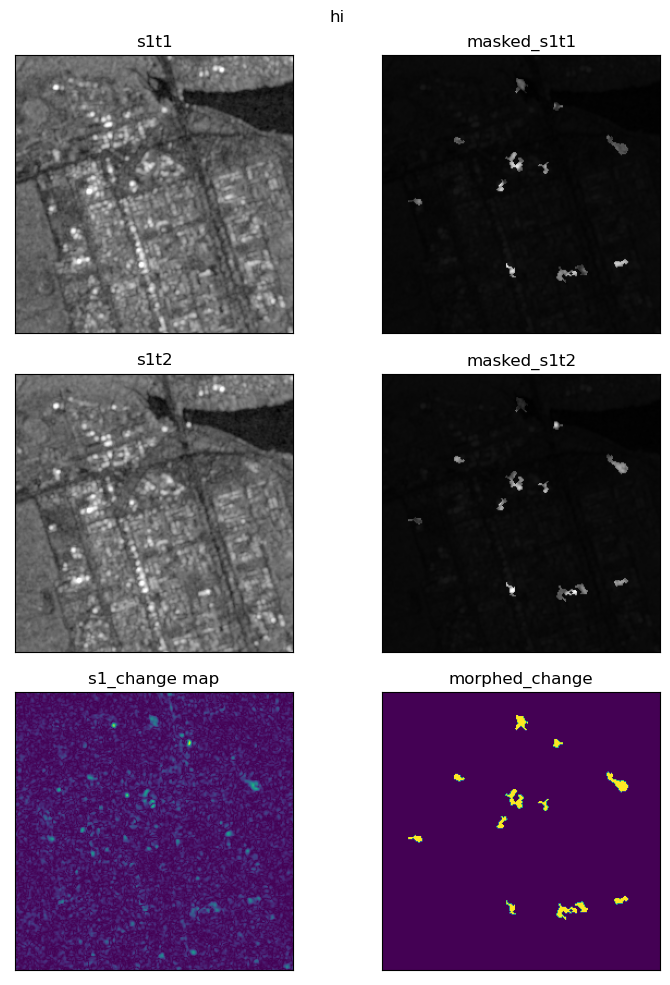

In [9525]:
input_list = [s1t1, masked_s1t1, s1t2, masked_s1t2, s1cm, morphed_image_tensor]
name_list = ["s1t1", "masked_s1t1", "s1t2",  "masked_s1t2",   "s1_change map", "morphed_change",]
save_s1s2_tensors_plot(input_list,
                        name_list,
                        n_rows=3,
                        n_cols=2,
                        filename=f"1.png",
                        fig_size=(8,10),
                        title="hi", just_show=True)

In [9526]:
name_list = os.listdir(s1_t1_dir_test)
name_list.sort()
name_list[rand_n]

'014_brasilia_r00_c00.tif'

In [9527]:
print(name_list[rand_n], get_ones_ratio(morphed_image) * 100, sep=",")

014_brasilia_r00_c00.tif,1.3092041015625


In [9528]:
row = f"{name_list[rand_n]},{get_ones_ratio(morphed_image) * 100}"
pyperclip.copy(row)